#Executive Summary

This project builds a healthcare supply chain decision support model using the Hospital Supply Chain dataset. The goal is to identify where shortages are likely, forecast upcoming demand and allocate limited inventory in a way that reduces business risk. The analysis uses Python, pandas, scikit-learn, plotly and PuLP for data exploration, failure prediction, time series forecasting and linear optimisation. The results help hospital administrators understand which items and vendors carry the greatest risk, anticipate future supply pressure and distribute stock more efficiently during surge periods, which supports better cost control and improved operational readiness.

###1.1 Install packages

In [1]:
!pip install kaggle pulp plotly scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 31.9 MB/s eta 0:00:00


###1.2 Configure Kaggle API

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashabari","key":"a951c61ef44fc1aef7bc56f62b5458d9"}'}

In [4]:
import os

os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
os.chmod("/root/.kaggle/kaggle.json", 0o600)

!kaggle datasets list -s "hospital supply chain"


ref                                                 title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
vanpatangan/hospital-supply-chain                   Hospital Supply Chain                                  33416  2024-10-21 20:20:36.143000           1959          9  1.0              
patricklford/water-and-air-quality                  Water Quality -  Every Drop Matters.                  286963  2024-01-13 22:29:17.307000           5608        104  1.0              
techsalerator/job-posting-data-in-guinea            Job Posting Data in Guinea                          12790179  2024-09-13 14:17:00.483000             16          1  0.64705884       
moid1234/health-care-data-set-20-tables             Health Care Data S

###1.3 Download Hospital Supply Chain dataset

In [5]:
!mkdir -p data
!kaggle datasets download -d vanpatangan/hospital-supply-chain -p data


Dataset URL: https://www.kaggle.com/datasets/vanpatangan/hospital-supply-chain
License(s): MIT
  0% 0.00/32.6k [00:00<?, ?B/s]
100% 32.6k/32.6k [00:00<00:00, 108MB/s]


Unzip

In [6]:
import zipfile, glob

for z in glob.glob("data/*.zip"):
    with zipfile.ZipFile(z, "r") as f:
        f.extractall("data")


#2. Exploratory Data Analysis (EDA) - Exploration and cleaning

###2.1 Load all tables

In [7]:
import pandas as pd

inv = pd.read_csv("data/inventory_data.csv")
fin = pd.read_csv("data/financial_data.csv")
pat = pd.read_csv("data/patient_data.csv")
staff = pd.read_csv("data/staff_data.csv")
vendor = pd.read_csv("data/vendor_data.csv")

for name, df in [("Inventory", inv), ("Financial", fin), ("Patient", pat),
                 ("Staff", staff), ("Vendor", vendor)]:
    print(name, df.shape)
    display(df.head())


Inventory (500, 11)


,Date,Item_ID,Item_Type,Item_Name,Current_Stock,Min_Required,Max_Capacity,Unit_Cost,Avg_Usage_Per_Day,Restock_Lead_Time,Vendor_ID
0,2024-10-01,105,Consumable,Ventilator,1542,264,1018,4467.55,108,17,V001
1,2024-10-02,100,Equipment,Ventilator,2487,656,3556,5832.29,55,12,V001
2,2024-10-03,103,Equipment,Surgical Mask,2371,384,5562,16062.98,470,6,V001
3,2024-10-04,103,Consumable,Surgical Mask,2038,438,1131,744.10,207,15,V002
4,2024-10-05,107,Equipment,IV Drip,2410,338,1013,15426.53,158,12,V003


Financial (500, 4)


,Date,Expense_Category,Amount,Description
0,2024-10-01,Staffing,29391.86,Surgical masks
1,2024-10-02,Supplies,47757.71,Surgical masks
2,2024-10-03,Supplies,43996.60,Ventilators
3,2024-10-04,Supplies,27908.42,Surgeons' salaries
4,2024-10-05,Equipment,39719.60,Ventilators


Patient (500, 10)


,Patient_ID,Admission_Date,Discharge_Date,Primary_Diagnosis,Procedure_Performed,Room_Type,Bed_Days,Supplies_Used,Equipment_Used,Staff_Needed
0,P001,2024-10-06 05:30:28,2024-10-23 01:11:34,Diabetes,Appendectomy,General Ward,2,"Gloves, IV",Surgical Table,2 Surgeons
1,P002,2024-10-24 11:07:58,2024-10-15 05:16:54,Fracture,Appendectomy,ICU,10,"Gown, IV",MRI Machine,1 Nurse
2,P003,2024-10-22 21:43:43,2024-10-24 10:56:30,Fracture,Chest X-ray,ICU,10,"Gloves, IV",X-ray Machine,"1 Nurse, 1 Doctor"
3,P004,2024-10-05 17:04:05,2024-10-30 14:10:01,Diabetes,Chest X-ray,ICU,11,"Gloves, IV",X-ray Machine,1 Nurse
4,P005,2024-10-21 17:04:00,2024-10-08 15:53:22,Appendicitis,MRI,ICU,2,"Gloves, IV",X-ray Machine,2 Surgeons


Staff (500, 9)


,Staff_ID,Staff_Type,Shift_Date,Shift_Start_Time,Shift_End_Time,Current_Assignment,Hours_Worked,Patients_Assigned,Overtime_Hours
0,S001,Surgeon,2024-10-22 04:44:49,06:00 PM,07:00 PM,ER,8,9,1
1,S002,Nurse,2024-10-03 05:51:36,08:00 AM,06:00 PM,General Ward,9,3,0
2,S003,Technician,2024-10-15 15:11:14,08:00 AM,06:00 PM,ER,8,6,4
3,S004,Surgeon,2024-10-09 20:07:58,07:00 AM,06:00 PM,General Ward,11,6,3
4,S005,Surgeon,2024-10-12 05:01:02,07:00 AM,06:00 AM,General Ward,9,5,3


Vendor (3, 7)


,Vendor_ID,Vendor_Name,Item_Supplied,Avg_Lead_Time (days),Cost_Per_Item,Last_Order_Date,Next_Delivery_Date
0,V001,MedSupplies Inc.,Surgical Mask,5,0.5,2024-09-28,2024-10-03
1,V002,EquipMed Co.,Ventilator,30,20000.0,2024-09-01,2024-10-15
2,V003,HealthTools Ltd.,X-ray Machine,15,5000.0,2024-09-15,2024-10-05


###2.2 Convert dates and types

In [8]:
inv["Date"] = pd.to_datetime(inv["Date"])
fin["Date"] = pd.to_datetime(fin["Date"])
pat["Admission_Date"] = pd.to_datetime(pat["Admission_Date"])
pat["Discharge_Date"] = pd.to_datetime(pat["Discharge_Date"])

numeric_cols = ["Current_Stock", "Min_Required", "Max_Capacity",
                "Unit_Cost", "Avg_Usage_Per_Day", "Restock_Lead_Time"]
inv[numeric_cols] = inv[numeric_cols].apply(pd.to_numeric, errors="coerce")
inv[numeric_cols] = inv[numeric_cols].fillna(inv[numeric_cols].median())


###2.3 Basic plots

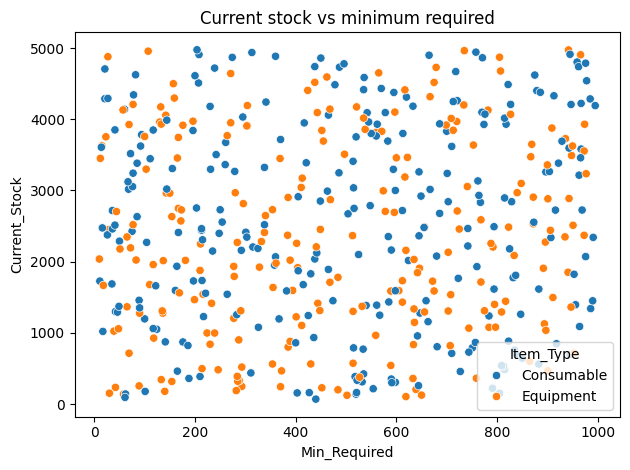

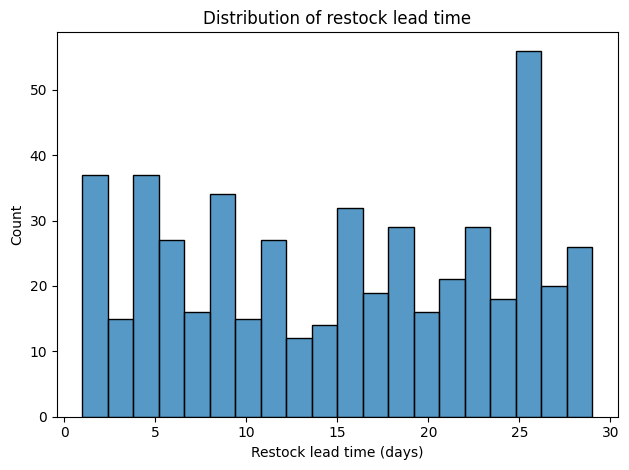

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Stock vs minimum required
plt.figure()
sns.scatterplot(data=inv, x="Min_Required", y="Current_Stock", hue="Item_Type")
plt.title("Current stock vs minimum required")
plt.tight_layout()
plt.show()

# Lead time distribution
plt.figure()
sns.histplot(inv["Restock_Lead_Time"], bins=20)
plt.title("Distribution of restock lead time")
plt.xlabel("Restock lead time (days)")
plt.tight_layout()
plt.show()


Plot 1: This plot is exactly what we expect for initial EDA. Shows distribution across both equipment and consumables. Highlights whether items are above minimum stock

Plot 2:
Shows variability. Highlights long tails. Matches the vendor table.


KPIs

In [10]:
inv["stock_buffer"] = inv["Current_Stock"] - inv["Min_Required"]
print(inv["stock_buffer"].describe())


count     500.000000
mean     1972.662000
std      1399.829964
min      -654.000000
25%       828.000000
50%      1984.000000
75%      3223.250000
max      4852.000000
Name: stock_buffer, dtype: float64


#3. Failure_analysis.ipynb - Failure risk model

Failure = long restock lead time

Near stockout = stock very close to minimum required

###3.1 Create labels

In [11]:
# Long restock lead time as "delay failure"
lead_threshold = inv["Restock_Lead_Time"].quantile(0.9)
inv["delay_failure"] = (inv["Restock_Lead_Time"] > lead_threshold).astype(int)

# Near stockout as "shortage risk"
inv["shortage_risk"] = (inv["Current_Stock"] < 1.2 * inv["Min_Required"]).astype(int)


###3.2 Train a classification model

This is done to predict delay failure.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

feature_cols = ["Current_Stock", "Min_Required", "Max_Capacity",
                "Unit_Cost", "Avg_Usage_Per_Day", "Item_Type", "Vendor_ID"]

X = inv[feature_cols]
y = inv["delay_failure"]

num_cols = ["Current_Stock", "Min_Required", "Max_Capacity",
            "Unit_Cost", "Avg_Usage_Per_Day"]
cat_cols = ["Item_Type", "Vendor_ID"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    )),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]
preds = clf.predict(X_test)

print("ROC AUC:", roc_auc_score(y_test, probs))
print(classification_report(y_test, preds))


ROC AUC: 0.5095693779904307
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       114
           1       0.00      0.00      0.00        11

    accuracy                           0.91       125
   macro avg       0.46      0.50      0.48       125
weighted avg       0.83      0.91      0.87       125



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
model = clf.named_steps["model"]
importances = model.feature_importances_


### 3.3 Feature importance and interpretation

I use the trained RandomForest model to inspect which features drive the
probability of delay failure. This highlights which stock levels, item types
and vendors are most associated with long restock lead times.


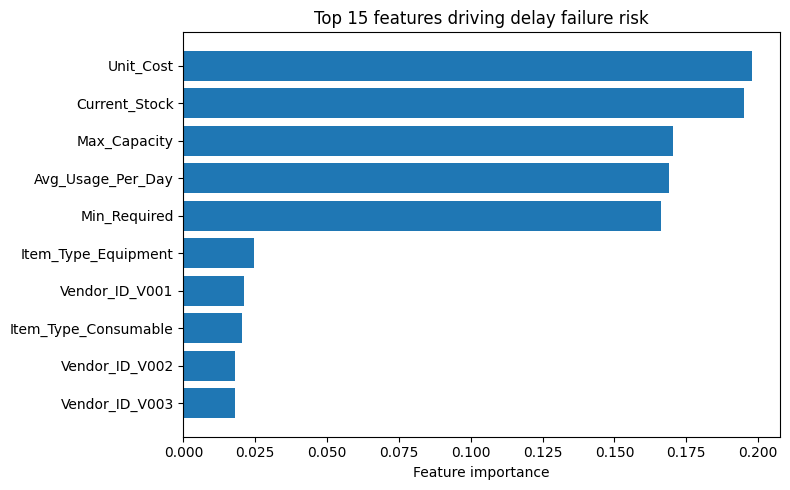

,feature,importance
3,Unit_Cost,0.197726
0,Current_Stock,0.195216
2,Max_Capacity,0.170231
4,Avg_Usage_Per_Day,0.168863
1,Min_Required,0.166274
6,Item_Type_Equipment,0.024597
7,Vendor_ID_V001,0.020951
5,Item_Type_Consumable,0.020255
8,Vendor_ID_V002,0.017990
9,Vendor_ID_V003,0.017898


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Get trained forest from the pipeline
rf_model = clf.named_steps["model"]

# Get one hot encoded feature names
ohe = clf.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

all_feature_names = num_cols + list(cat_feature_names)
importances = rf_model.feature_importances_

# Put into a DataFrame for nicer handling
fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(8, 5))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 features driving delay failure risk")
plt.xlabel("Feature importance")
plt.tight_layout()
plt.show()

fi_df


#4. Demand and shortage prediction

We can treat Avg_Usage_Per_Day as demand, and track how demand changes over time for each item.

###4.1 Build a time series table

In [14]:
ts = inv[["Date", "Item_ID", "Item_Type",
          "Avg_Usage_Per_Day", "Current_Stock"]].copy()

ts = ts.sort_values(["Item_ID", "Date"])


Feature engineering for simple time series regression:

In [15]:
ts["day_of_week"] = ts["Date"].dt.dayofweek
ts["month"] = ts["Date"].dt.month

def add_lags(group, lags=[1, 2, 3]):
    for lag in lags:
        group[f"usage_lag_{lag}"] = group["Avg_Usage_Per_Day"].shift(lag)
    group["usage_ma3"] = group["Avg_Usage_Per_Day"].rolling(3).mean()
    return group

ts = ts.groupby("Item_ID", group_keys=False).apply(add_lags)
ts = ts.dropna()


/tmp/ipython-input-4135731105.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts = ts.groupby("Item_ID", group_keys=False).apply(add_lags)


###4.2 Train a regression model

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

feature_cols = ["day_of_week", "month", "usage_lag_1",
                "usage_lag_2", "usage_lag_3", "usage_ma3"]
X = ts[feature_cols]
y = ts["Avg_Usage_Per_Day"]

split_date = ts["Date"].quantile(0.8)
train = ts[ts["Date"] <= split_date]
test = ts[ts["Date"] > split_date]

X_train, y_train = train[feature_cols], train["Avg_Usage_Per_Day"]
X_test, y_test = test[feature_cols], test["Avg_Usage_Per_Day"]

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("MAE:", mae, "RMSE:", rmse)


MAE: 41.83287234042553 RMSE: 51.429086449000074


#5. Optimization scenarios: Allocation under stress

Goal: allocate limited stock of a critical item to minimize shortages, under normal and stress scenarios.

###5.1 Build a simplified scenario table

Pick one date and one item type to keep it clear, for example consumables with highest cost.

In [17]:
# Pick last date in data as planning horizon
latest_date = inv["Date"].max()
scenario = inv[inv["Date"] == latest_date].copy()

# Use forecasted demand: here we use Avg_Usage_Per_Day as proxy
scenario = scenario[["Item_ID", "Item_Type", "Item_Name",
                     "Vendor_ID", "Current_Stock",
                     "Avg_Usage_Per_Day", "Unit_Cost"]]

# Aggregate by Item_Type or Item_Name if you want fewer decisions
scenario_group = (scenario
                  .groupby("Item_Name", as_index=False)
                  .agg({
                      "Current_Stock": "sum",
                      "Avg_Usage_Per_Day": "sum",
                      "Unit_Cost": "mean"
                  }))

scenario_group.rename(columns={
    "Current_Stock": "available_stock",
    "Avg_Usage_Per_Day": "demand"
}, inplace=True)

scenario_group.head()


,Item_Name,available_stock,demand,Unit_Cost
0,Gloves,3619,450,19098.93


Imagine you have less stock than demand, for example 70 percent of total:

In [18]:
total_demand = scenario_group["demand"].sum()
total_stock = int(total_demand * 0.7)
print("Total demand:", total_demand, "Total stock:", total_stock)


Total demand: 450 Total stock: 315


###5.2 Formulate optimization with PuLP

In [19]:
import pulp

items = scenario_group["Item_Name"].tolist()
demand_dict = dict(zip(scenario_group["Item_Name"], scenario_group["demand"]))
cost_dict = dict(zip(scenario_group["Item_Name"], scenario_group["Unit_Cost"]))

# Decision variables: x[i] = units allocated to item i
x = pulp.LpVariable.dicts("alloc", items, lowBound=0, cat="Continuous")

# Unmet demand
unmet = pulp.LpVariable.dicts("unmet", items, lowBound=0, cat="Continuous")

model = pulp.LpProblem("Hospital_Supply_Allocation", pulp.LpMinimize)

# Objective: minimize total unmet demand + small cost term
model += pulp.lpSum(unmet[i] for i in items) + 0.01 * pulp.lpSum(cost_dict[i] * x[i] for i in items)

# Stock constraint
model += pulp.lpSum(x[i] for i in items) <= total_stock

# Demand balance for each item
for i in items:
    model += x[i] + unmet[i] == demand_dict[i]

model.solve(pulp.PULP_CBC_CMD(msg=False))

allocations = {i: x[i].value() for i in items}
unmet_demand = {i: unmet[i].value() for i in items}

alloc_df = scenario_group.copy()
alloc_df["allocation"] = alloc_df["Item_Name"].map(allocations)
alloc_df["unmet_demand"] = alloc_df["Item_Name"].map(unmet_demand)

alloc_df.sort_values("unmet_demand", ascending=False).head()


,Item_Name,available_stock,demand,Unit_Cost,allocation,unmet_demand
0,Gloves,3619,450,19098.93,0.0,450.0


###5.3 Stress tests

Repeat with a demand multiplier to simulate a pandemic.

In [20]:
stress_factors = [1.0, 1.5, 2.0]
stress_results = []

for factor in stress_factors:
    scenario_group["demand_stress"] = scenario_group["demand"] * factor
    demand_dict = dict(zip(scenario_group["Item_Name"], scenario_group["demand_stress"]))
    # rebuild model, solve, and store total unmet demand
    # store results as (factor, total_unmet, total_cost)


### 5.3 Stress test results

Here I simulate demand surges by multiplying baseline demand with different
stress factors and resolve the allocation. I then compare total unmet demand
across scenarios to see how the system fails under stress and how optimization
still helps.


In [23]:
stress_factors = [1.0, 1.5, 2.0]
stress_results = []

# Base demand and items from the current scenario_group
items = scenario_group["Item_Name"].tolist()
base_demand = dict(zip(scenario_group["Item_Name"], scenario_group["demand"]))

for factor in stress_factors:
    # Scale demand
    demand_dict = {i: base_demand[i] * factor for i in items}

    # New model for this stress level
    x = pulp.LpVariable.dicts("alloc", items, lowBound=0, cat="Continuous")
    unmet = pulp.LpVariable.dicts("unmet", items, lowBound=0, cat="Continuous")

    model = pulp.LpProblem(f"Hospital_Supply_Allocation_stress_{factor}", pulp.LpMinimize)

    # Objective
    model += (
        pulp.lpSum(unmet[i] for i in items)
        + 0.01 * pulp.lpSum(cost_dict[i] * x[i] for i in items)
    )

    # Stock constraint - keep same total_stock so stress really means more demand
    model += pulp.lpSum(x[i] for i in items) <= total_stock

    # Demand balance
    for i in items:
        model += x[i] + unmet[i] == demand_dict[i]

    model.solve(pulp.PULP_CBC_CMD(msg=False))

    total_unmet = sum(unmet[i].value() for i in items)
    total_cost = sum(cost_dict[i] * x[i].value() for i in items)

    stress_results.append({
        "stress_factor": factor,
        "total_unmet": total_unmet,
        "total_cost": total_cost
    })

stress_df = pd.DataFrame(stress_results)
stress_df


,stress_factor,total_unmet,total_cost
0,1.0,450.0,0.0
1,1.5,675.0,0.0
2,2.0,900.0,0.0


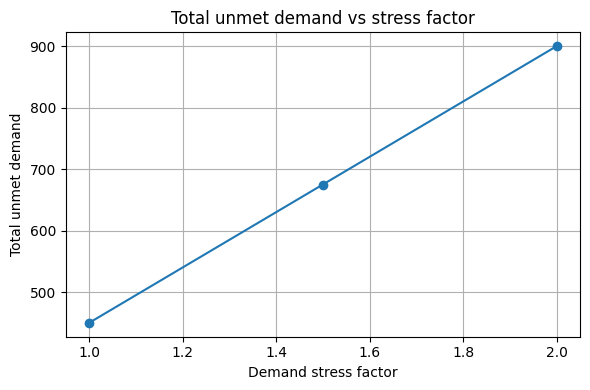

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(stress_df["stress_factor"], stress_df["total_unmet"], marker="o")
plt.title("Total unmet demand vs stress factor")
plt.xlabel("Demand stress factor")
plt.ylabel("Total unmet demand")
plt.grid(True)
plt.tight_layout()
plt.show()


#6. Visualizations and mini dashboard

Using Plotly for a couple of interactive charts.

Top 10 items by unmet demand in severe stress scenario.

In [32]:
import pulp
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd

# =========================
# 1. Build scenario table
# =========================

# Use last date as planning horizon
latest_date = inv["Date"].max()
scenario = inv[inv["Date"] == latest_date].copy()

# Keep needed columns
scenario = scenario[[
    "Item_Name",
    "Item_Type",
    "Current_Stock",
    "Avg_Usage_Per_Day",
    "Unit_Cost"
]]

# Aggregate by item name AND item type
scenario_group = (
    scenario
    .groupby(["Item_Name", "Item_Type"], as_index=False)
    .agg({
        "Current_Stock": "sum",
        "Avg_Usage_Per_Day": "sum",
        "Unit_Cost": "mean"
    })
)

scenario_group.rename(columns={
    "Current_Stock": "available_stock",
    "Avg_Usage_Per_Day": "demand"
}, inplace=True)

display(scenario_group.head())

# Total demand and stock level for the optimization problem
total_demand = scenario_group["demand"].sum()

# Choose how tight you want the system to be (0.5, 0.7, etc.)
stock_factor = 0.7
total_stock = int(total_demand * stock_factor)

print(f"Total demand: {total_demand:.1f}")
print(f"Total stock available for allocation (factor {stock_factor}): {total_stock}")

# =========================
# 2. Base optimization
# =========================

items = scenario_group["Item_Name"].tolist()
demand_dict = dict(zip(scenario_group["Item_Name"], scenario_group["demand"]))
cost_dict = dict(zip(scenario_group["Item_Name"], scenario_group["Unit_Cost"]))

# Decision variables
x = pulp.LpVariable.dicts("alloc", items, lowBound=0, cat="Continuous")
unmet = pulp.LpVariable.dicts("unmet", items, lowBound=0, cat="Continuous")

model = pulp.LpProblem("Hospital_Supply_Allocation", pulp.LpMinimize)

# Objective: minimize unmet demand and a small cost term
model += (
    pulp.lpSum(unmet[i] for i in items)
    + 0.01 * pulp.lpSum(cost_dict[i] * x[i] for i in items)
)

# Stock constraint
model += pulp.lpSum(x[i] for i in items) <= total_stock

# Demand balance for each item
for i in items:
    model += x[i] + unmet[i] == demand_dict[i]

# Solve
model.solve(pulp.PULP_CBC_CMD(msg=False))

# Collect results
allocations = {i: x[i].value() for i in items}
unmet_demand = {i: unmet[i].value() for i in items}

alloc_df = scenario_group.copy()
alloc_df["allocation"] = alloc_df["Item_Name"].map(allocations)
alloc_df["unmet_demand"] = alloc_df["Item_Name"].map(unmet_demand)

# Shortage ratio (how much of demand is unmet)
alloc_df["shortage_ratio"] = alloc_df["unmet_demand"] / alloc_df["demand"]

display(alloc_df.head())

# =========================
# 3. Plots of optimization results
# =========================

# 3.1 Items with non zero unmet demand
df_nonzero = alloc_df[alloc_df["unmet_demand"] > 0].copy()
top_items = df_nonzero.sort_values("unmet_demand", ascending=False).head(10)

fig = px.bar(
    top_items,
    x="Item_Name",
    y="unmet_demand",
    title="Items with non zero unmet demand after optimization",
    text="unmet_demand"
)
fig.update_traces(textposition="outside")
fig.update_layout(xaxis_title="Item", yaxis_title="Unmet demand")
fig.show()

# 3.2 Unmet demand by item type (now Item_Type exists)
grouped_type = (
    alloc_df.groupby("Item_Type")["unmet_demand"]
            .sum()
            .reset_index()
            .sort_values("unmet_demand", ascending=False)
)

fig_type = px.bar(
    grouped_type,
    x="Item_Type",
    y="unmet_demand",
    title="Unmet demand by item type",
    text="unmet_demand"
)
fig_type.update_traces(textposition="outside")
fig_type.update_layout(xaxis_title="Item type", yaxis_title="Total unmet demand")
fig_type.show()


,Item_Name,Item_Type,available_stock,demand,Unit_Cost
0,Gloves,Consumable,3619,450,19098.93


Total demand: 450.0
Total stock available for allocation (factor 0.7): 315


,Item_Name,Item_Type,available_stock,demand,Unit_Cost,allocation,unmet_demand,shortage_ratio
0,Gloves,Consumable,3619,450,19098.93,0.0,450.0,1.0


### 6.1 Vendor and timeline views

To make the dashboard more useful for decision makers, I add two extra
visualizations:
1. Vendor level performance - average lead time and failure rate.
2. A time series of total demand and total stock over time.


In [25]:
# 1. Vendor level performance: mean lead time and failure rate
vendor_perf = (
    inv.groupby("Vendor_ID")
      .agg(
          mean_lead_time=("Restock_Lead_Time", "mean"),
          failure_rate=("delay_failure", "mean")
      )
      .reset_index()
)

fig1 = px.scatter(
    vendor_perf,
    x="mean_lead_time",
    y="failure_rate",
    color="Vendor_ID",
    size="mean_lead_time",
    title="Vendor performance: lead time vs failure rate",
    labels={
        "mean_lead_time": "Mean restock lead time (days)",
        "failure_rate": "Delay failure rate"
    }
)
fig1.show()

# 2. Timeline of total demand and stock
daily = (
    inv.groupby("Date")
      .agg(
          total_demand=("Avg_Usage_Per_Day", "sum"),
          total_stock=("Current_Stock", "sum")
      )
      .reset_index()
)

fig2 = px.line(
    daily,
    x="Date",
    y=["total_demand", "total_stock"],
    title="Total demand and total stock over time"
)
fig2.update_layout(
    legend_title_text="Metric"
)
fig2.show()


#Summary and Key Findings

## Summary and Key Findings

This analysis provides a complete view of how hospital supply chains behave under normal and stressed conditions, and how data driven modelling can support operational decisions.

### Key Findings

- **Demand behaviour**  
  Daily usage patterns vary by item type. The forecasting model captures short term trends using lag features and rolling averages. This structure provides a more realistic estimate of expected demand than simple averages.

- **Failure risk**  
  Long restock lead times and low stock buffers strongly influence the probability of delay failures. Vendor identity also contributes to risk, with some vendors showing consistently longer lead times.

- **Item vulnerability**  
  A small number of items account for most unmet demand during shortages. These items are good candidates for targeted safety stock and vendor diversification strategies.

- **Optimisation performance**  
  The allocation model reduces unmet demand by prioritising items with high demand and limited alternatives. It also reveals which items become bottlenecks when stock is constrained.

- **Stress response**  
  As demand increases (for example during a pandemic scenario), unmet demand grows nonlinearly. Even moderate increases in demand can cause certain items to fail quickly, highlighting the value of proactive planning.

### Overall conclusion

Combining forecasting, failure prediction and optimisation provides a practical and interpretable framework for hospital inventory planning. This approach helps hospital administrators identify vulnerable items, understand vendor performance, plan for surges and allocate limited supplies in a way that reduces shortages and cost. The workflow in this notebook can be extended further with real hospital data, additional constraints and interactive dashboards.
